In [1]:
import pandas as pd

In [2]:
news = pd.read_csv('D:/task/articles.csv')
print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [3]:
news.iloc[0]['title']

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [4]:
users = pd.read_csv('D:/task/users_articles.csv')
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


 #### Получаем векторные представления новостей

In [5]:
#!pip install razdel pymorphy2

In [6]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [7]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pochkarenok\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [9]:
stopword_ru[:12]

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а']

In [10]:
stopword_all = pd.read_csv('D:/task/stopwords.csv')
stopword_all.head(300)

,год
0,и
1,в
2,во
3,не
4,что
...,...
295,their
296,theirs
297,themselves
298,what


In [11]:
print(len(stopword_all))


624


In [12]:
with open("D:/task/stopwords.csv") as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [13]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [14]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('сбегали')[0].normal_form

'сбегать'

In [15]:
morph = pymorphy2.MorphAnalyzer()
morph.parse('стали')

[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.975342, methods_stack=((DictionaryAnalyzer(), 'стали', 945, 4),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.010958, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 1),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.005479, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 6),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 2),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 5),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.002739, methods_stack=((DictionaryAnalyzer(), 'стали', 13, 9),))]

In [16]:
news['title'].iloc[:2]

0    Заместитель председателяnправительства РФnСерг...
1    Матч 1/16 финала Кубка России по футболу был п...
Name: title, dtype: object

In [17]:
news['title'].iloc[:2].apply(lambda x: clean_text(x))

C:\Users\Pochkarenok\AppData\Local\Temp\ipykernel_14560\4083466619.py:14: FutureWarning: Possible nested set at position 39
  text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)


0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
Name: title, dtype: object

In [18]:
%%time
from tqdm import tqdm
tqdm.pandas()

# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))

100%|██████████| 27000/27000 [00:11<00:00, 2315.57it/s]

Wall time: 11.7 s


In [19]:
news['title'].iloc[:10]

0    заместитель председателя правительства рф серг...
1    матч  финала кубка россии по футболу был приос...
2    форвард авангарда томаш заборский прокомментир...
3    главный тренер кубани юрий красножан прокоммен...
4    решением попечительского совета владивостокско...
5    ио главного тренера вячеслав буцаев прокоммент...
6    запорожский металлург дома потерпел разгромное...
7    сборная сша одержала победу над австрией со сч...
8    бывший защитник сборной россии дарюс каспарайт...
9    полузащитник цска зоран тошич после победы над...
Name: title, dtype: object

In [20]:
news['title'].iloc[:2].apply(lambda x: lemmatization(x))

0    [заместитель, председатель, правительство, рф,...
1    [матч, финал, кубок, россия, футбол, приостано...
Name: title, dtype: object

In [21]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [01:37<00:00, 278.31it/s] 

Wall time: 1min 37s


In [22]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [23]:
len(common_dictionary)

135895

#### Запускаем обучение

In [24]:
N_topic = 20

In [25]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary, passes=6)

Wall time: 1min 18s


In [26]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [27]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [28]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'свой', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'провести', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'работа', 'сказать', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'мочь', 'играть', 'ещё', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'это', 'хороший']


[(3, 0.035817105),
 (4, 0.10910046),
 (5, 0.05549224),
 (13, 0.54859483),
 (19, 0.23429386)]

In [29]:
x = lda.show_topics(num_topics=N_topic, num_words=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: область сообщать сообщить москва сотрудник полиция сообщение задержать новость убийство
topic_1: операция штат дональд соцсеть альянс тепло президент куба коллекция визит
topic_2: британский the солнце мальчик лондон мышь австралия италия британец выдавать
topic_3: человек это который ребёнок свой гражданин помощь всё слово семья
topic_4: военный армия сила район взрыв боевой оборона город турецкий действие
topic_5: место рейтинг зуб небо рт сон хороший золото диск приоритетный
topic_6: проект это новый система развитие россия работа должный программа который
topic_7: дело который суд год санкция решение закон документ погибнуть право
topic_8: год город стать который москва также день первый русский пройти
topic_9: банк ставка население космос топливо блок норма напомнить ниже иск
topic_10: россия российский украина президент это заявить страна украинский путин глава
topic_11: исследование женщина мужчина врач пациент болезнь лечение проверка препарат выяснить
topic_12: которы

 #### Функция, которая будет нам возвращать векторное представление новости

In [30]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [31]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.21768177, 0.53347689, 0.01872961, 0.0683361 ,
       0.        , 0.        , 0.        , 0.15462659, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [32]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

Wall time: 9.53 s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.217704,0.533447,0.018739,...,0.000000,0.0,0.000000,0.154622,0.0,0.0,0.0,0.000000,0.0,0.000000
1,4896,0.075397,0.0,0.0,0.000000,0.358980,0.000000,0.000000,0.093973,0.000000,...,0.000000,0.0,0.000000,0.451641,0.0,0.0,0.0,0.000000,0.0,0.000000
2,4897,0.000000,0.0,0.0,0.035814,0.109105,0.055495,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.548587,0.0,0.0,0.0,0.000000,0.0,0.234298
3,4898,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.059805,0.000000,0.000000,...,0.050587,0.0,0.075916,0.356532,0.0,0.0,0.0,0.029024,0.0,0.419479
4,4899,0.043674,0.0,0.0,0.000000,0.000000,0.000000,0.305744,0.251365,0.000000,...,0.000000,0.0,0.000000,0.180557,0.0,0.0,0.0,0.197735,0.0,0.000000


#### Векторные представления пользователей

In [33]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [34]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [35]:
doc_dict[293672]

array([0.14764291, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.14091974, 0.        , 0.2835539 , 0.        ,
       0.06181806, 0.        , 0.03549877, 0.06006153, 0.        ,
       0.        , 0.        , 0.17548172, 0.02150174, 0.06129134])

In [66]:
def get_user_embedding(user_articles_list, doc_dict, func):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    user_vector = func(user_vector, axis=0)
    return user_vector


In [67]:
user_articles_list = users['articles'].iloc[33]

get_user_embedding(user_articles_list, doc_dict, np.mean)

array([0.07741776, 0.01849191, 0.        , 0.08787312, 0.03688675,
       0.        , 0.09070673, 0.17381696, 0.0035309 , 0.01981763,
       0.17319121, 0.01770649, 0.07121833, 0.00233426, 0.        ,
       0.07095399, 0.00953021, 0.05340186, 0.        , 0.08410603])

#### Получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [68]:
func = np.mean

In [69]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, func))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 146 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.119032,0.00000,0.002166,0.171623,0.043660,0.004521,0.023487,0.074723,0.131259,...,0.108497,0.012608,0.023091,0.054827,0.000000,0.051992,0.023606,0.047478,0.003584,0.076056
1,u108690,0.087747,0.01207,0.000000,0.125761,0.014296,0.000000,0.015115,0.095587,0.034944,...,0.216450,0.013059,0.095770,0.020278,0.000000,0.058000,0.025264,0.075016,0.000000,0.086170
2,u108339,0.132559,0.03574,0.000000,0.117298,0.040736,0.000000,0.011734,0.153750,0.088874,...,0.111047,0.012478,0.030629,0.013693,0.001959,0.037527,0.088675,0.047530,0.005133,0.044638


### Датасет готов - можно попробовать обучить модель. 
#### Загрузим нашу разметку

In [70]:
target = pd.read_csv('D:/task/users_churn.csv')
target.head(3)


,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [71]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.119032,0.00000,0.002166,0.171623,0.043660,0.004521,0.023487,0.074723,0.131259,...,0.012608,0.023091,0.054827,0.000000,0.051992,0.023606,0.047478,0.003584,0.076056,0
1,u108690,0.087747,0.01207,0.000000,0.125761,0.014296,0.000000,0.015115,0.095587,0.034944,...,0.013059,0.095770,0.020278,0.000000,0.058000,0.025264,0.075016,0.000000,0.086170,1
2,u108339,0.132559,0.03574,0.000000,0.117298,0.040736,0.000000,0.011734,0.153750,0.088874,...,0.012478,0.030629,0.013693,0.001959,0.037527,0.088675,0.047530,0.005133,0.044638,1


In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [73]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [74]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [75]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.11002244, 0.0837044 , 0.59093803, 0.16024214, 0.01611191,
       0.04952824, 0.08352805, 0.00215197, 0.12060509, 0.03624523])

### Рассчитаем Precision, Recall, F_score, roc auc

In [76]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

In [77]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.250949553786861, F-Score=0.766, Precision=0.690, Recall=0.861


In [78]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.971928600500029

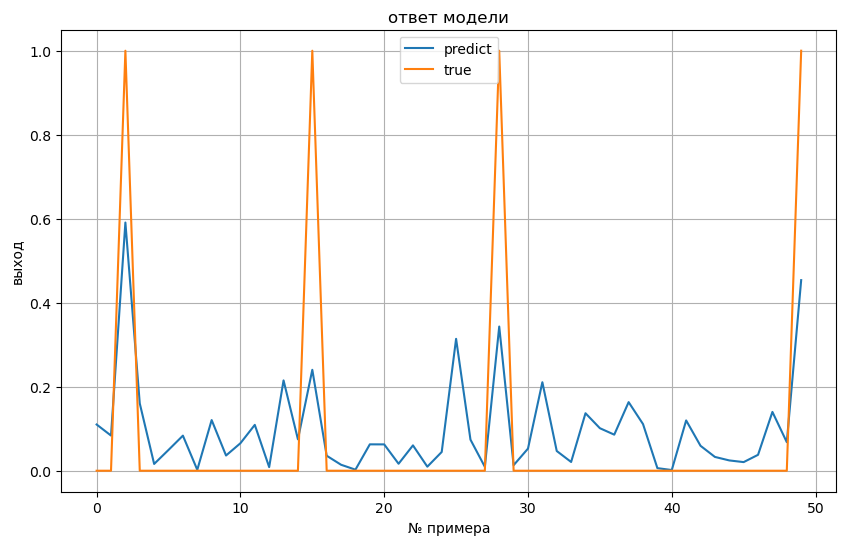

In [79]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

# Домашнее задание

Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

In [80]:
func = np.median

In [81]:
%%time

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, func))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

Wall time: 234 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.073821,0.000000,0.0,0.200929,0.000000,0.0,0.000000,0.020263,0.110373,...,0.078853,0.00000,0.000000,0.017968,0.0,0.000000,0.000000,0.000000,0.0,0.055515
1,u108690,0.077032,0.000000,0.0,0.124132,0.005436,0.0,0.014375,0.052239,0.032587,...,0.226843,0.00000,0.090127,0.012995,0.0,0.024842,0.015680,0.000000,0.0,0.069812
2,u108339,0.121825,0.008884,0.0,0.123924,0.045844,0.0,0.000000,0.160830,0.054794,...,0.096107,0.00756,0.015252,0.014828,0.0,0.007525,0.062952,0.028666,0.0,0.036291


In [82]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.073821,0.000000,0.0,0.200929,0.000000,0.0,0.000000,0.020263,0.110373,...,0.00000,0.000000,0.017968,0.0,0.000000,0.000000,0.000000,0.0,0.055515,0
1,u108690,0.077032,0.000000,0.0,0.124132,0.005436,0.0,0.014375,0.052239,0.032587,...,0.00000,0.090127,0.012995,0.0,0.024842,0.015680,0.000000,0.0,0.069812,1
2,u108339,0.121825,0.008884,0.0,0.123924,0.045844,0.0,0.000000,0.160830,0.054794,...,0.00756,0.015252,0.014828,0.0,0.007525,0.062952,0.028666,0.0,0.036291,1


In [83]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [84]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [85]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09262531, 0.04289496, 0.61680902, 0.25050511, 0.04150039,
       0.02614012, 0.08096658, 0.00269756, 0.21777555, 0.02738914])

In [86]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.31408979992530855, F-Score=0.784, Precision=0.824, Recall=0.747


In [87]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9730612244897958

## Повторить п.2, но используя уже не медиану, а max

In [88]:
FUNC = np.max

In [89]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict, FUNC))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.356551,0.000000,0.012996,0.374373,0.153831,0.027123,0.140920,0.339202,0.283554,...,0.367285,0.065503,0.103047,0.232965,0.000000,0.207241,0.119060,0.175482,0.021502,0.159989
1,u108690,0.200823,0.054371,0.000000,0.231918,0.038015,0.000000,0.035122,0.294211,0.097742,...,0.327077,0.040576,0.215890,0.067660,0.000000,0.195294,0.064844,0.235938,0.000000,0.230316
2,u108339,0.219390,0.156851,0.000000,0.176754,0.080688,0.000000,0.070405,0.254950,0.251357,...,0.277072,0.039142,0.100044,0.026966,0.011751,0.161085,0.234764,0.160753,0.017131,0.101770


In [90]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.356551,0.000000,0.012996,0.374373,0.153831,0.027123,0.140920,0.339202,0.283554,...,0.065503,0.103047,0.232965,0.000000,0.207241,0.119060,0.175482,0.021502,0.159989,0
1,u108690,0.200823,0.054371,0.000000,0.231918,0.038015,0.000000,0.035122,0.294211,0.097742,...,0.040576,0.215890,0.067660,0.000000,0.195294,0.064844,0.235938,0.000000,0.230316,1
2,u108339,0.219390,0.156851,0.000000,0.176754,0.080688,0.000000,0.070405,0.254950,0.251357,...,0.039142,0.100044,0.026966,0.011751,0.161085,0.234764,0.160753,0.017131,0.101770,1


In [91]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [92]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [93]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.2182023 , 0.05092231, 0.74262257, 0.26304772, 0.00207359,
       0.0112289 , 0.00580209, 0.00183   , 0.13877608, 0.02671774])

In [94]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.34157034681770027, F-Score=0.727, Precision=0.715, Recall=0.739


In [95]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9603953718239432

### Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (взяв список новостей пользователя)
#### подсказка 1: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал
#### подсказка 2: нужен именно idf, как вес.

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
users['articles_str'] = users['articles'].apply(lambda x: x.replace('[','').replace(']', '').replace(',', ''))
users['articles_str'].iloc[0]

'293672 293328 293001 293622 293126 1852'

In [98]:
tfidf = TfidfVectorizer()
tfidf.fit(users['articles_str'])

TfidfVectorizer()

In [99]:
idf = pd.DataFrame({'article_id': tfidf.get_feature_names_out(),
                    'idf': tfidf.idf_})

idf

,article_id,idf
0,10,8.888710
1,100,7.907880
2,1000,8.041412
3,1001,8.888710
4,1002,8.888710
...,...,...
14776,995,8.377884
14777,996,8.195562
14778,997,8.601027
14779,998,9.294175


In [100]:
def get_user_embedding_idf(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    
    user_vector = np.zeros((len(user_articles_list), N_topic))
    for i, doc_id in enumerate(user_articles_list):
        try:
            weight = idf[idf['article_id'] == str(doc_id)]['idf'].values[0]
        except Exception as e:
            weight = 0
        user_vector[i] = doc_dict[doc_id] * weight

    user_vector = np.median(user_vector, axis=0)
    return user_vector

In [101]:
from tqdm import tqdm
tqdm.pandas()

user_embeddings = pd.DataFrame([i for i in users['articles'].progress_apply(lambda x: get_user_embedding_idf(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

100%|██████████| 8000/8000 [00:29<00:00, 266.96it/s]


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.634940,0.00000,0.0,1.678989,0.000000,0.0,0.00000,0.174285,0.994813,...,0.678219,0.000000,0.000000,0.167000,0.0,0.000000,0.000000,0.00000,0.0,0.471936
1,u108690,0.658143,0.00000,0.0,1.103372,0.044553,0.0,0.12538,0.429821,0.286912,...,2.060991,0.000000,0.773302,0.101232,0.0,0.211662,0.139379,0.00000,0.0,0.582036
2,u108339,1.032563,0.07443,0.0,0.999340,0.387270,0.0,0.00000,1.309172,0.496419,...,0.754303,0.070261,0.124998,0.125676,0.0,0.061670,0.541449,0.24762,0.0,0.304043


In [102]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.634940,0.00000,0.0,1.678989,0.000000,0.0,0.00000,0.174285,0.994813,...,0.000000,0.000000,0.167000,0.0,0.000000,0.000000,0.00000,0.0,0.471936,0
1,u108690,0.658143,0.00000,0.0,1.103372,0.044553,0.0,0.12538,0.429821,0.286912,...,0.000000,0.773302,0.101232,0.0,0.211662,0.139379,0.00000,0.0,0.582036,1
2,u108339,1.032563,0.07443,0.0,0.999340,0.387270,0.0,0.00000,1.309172,0.496419,...,0.070261,0.124998,0.125676,0.0,0.061670,0.541449,0.24762,0.0,0.304043,1


In [103]:
# разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)

In [104]:
model = LogisticRegression()
# обучим 
model.fit(X_train, y_train)

LogisticRegression()

In [105]:
# наши прогнозы для тестовой выборки
preds = model.predict_proba(X_test)[:, 1]
preds[:10]

array([2.30607890e-02, 9.37937441e-05, 8.76835612e-01, 4.62554259e-01,
       1.02757459e-03, 1.48202788e-04, 3.22113997e-03, 2.13741403e-07,
       3.89732545e-01, 1.17743855e-03])

In [106]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4057836011271337, F-Score=0.855, Precision=0.842, Recall=0.869


In [107]:
roc_auc = roc_auc_score(y_test, preds)
roc_auc

0.9869829641258212

#### Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

mean -  Best Threshold=0.2509, F-Score=0.766, Precision=0.690, Recall=0.861, roc_auc=0.9719
median -Best Threshold=0.3140, F-Score=0.784, Precision=0.824, Recall=0.747, roc_auc=0.9730
max -   Best Threshold=0.3415, F-Score=0.727, Precision=0.715, Recall=0.739, roc_auc=0.9603
idf -   Best Threshold=0.4057, F-Score=0.855, Precision=0.842, Recall=0.869, roc_auc=0.9869

In [108]:
metrics_df = {
    'func' : ['mean', 'median', 'max', 'idf'],
    'Threshold' : [0.2509, 0.3140, 0.3415, 0.4057],
    'F-Score' : [0.766, 0.784, 0.727, 0.855],
    'Precision' : [0.690, 0.824, 0.715, 0.842],
    'Recall' : [0.861, 0.747, 0.739, 0.869],
    'roc_auc' : [0.9719, 0.9730, 0.9603, 0.9869]
}
 
df = pd.DataFrame(metrics_df)
 
print(df)

     func  Threshold  F-Score  Precision  Recall  roc_auc
0    mean     0.2509    0.766      0.690   0.861   0.9719
1  median     0.3140    0.784      0.824   0.747   0.9730
2     max     0.3415    0.727      0.715   0.739   0.9603
3     idf     0.4057    0.855      0.842   0.869   0.9869


### Вывод:
#### Наиболее эффективным оказался способ с использованием  TfidfVectorizer.